<a href="https://colab.research.google.com/github/larinsi/DS0P/blob/main/Machine_learning_Middle_level_Neural_networks/07_Semantic_segmentation_Pt2/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация U-Net
В этом уроке мы создадим еще более качественную FCN модель на основе архитектуры UNet. Кроме использовавшихся ранее слоёв, здесь также будут участвовать Skipped Connections (проброшенные связи).

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.


In [1]:
import numpy as np

import tensorflow as tf
# tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.0


### Создание UNet модели
Так как UNet имееет разветвления, мы не сможем создать её с помощью `tf.keras.Sequential`. Остаётся либо создать свой собственный класс, либо использовать функциональный API. Так как граф у нас будет статический (без каких-то условных ветвлений), и нам потом желательно визуализировать полученный граф, чтобы проверить, что мы всё соединили правильно, мы будем использовать именно функциональный API.

В архитектуре UNet для понижения размерности используется MaxPooling, а для повышения -- Conv2DTranspose (Транспонированная свёртка, Upconv). Кроме того, присутствуют проброшенные связи (skipped connections): некоторые тензоры из Энкодера конкатенируются по канальному измерению (axis=3) с тензорами из Декодера. В остальном эта модель очень похожа на обычныйю Encoder-Decoder нейросеть из предыдущего практического урока.

В отличие от классической UNet архитектуры, мы во всех слоях  будем использовать `padding='same'`, чтобы избавиться от необходимости делать crop при конкатинации тензоров из разных участков сети.

In [2]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

### Визуализация графа модели UNet

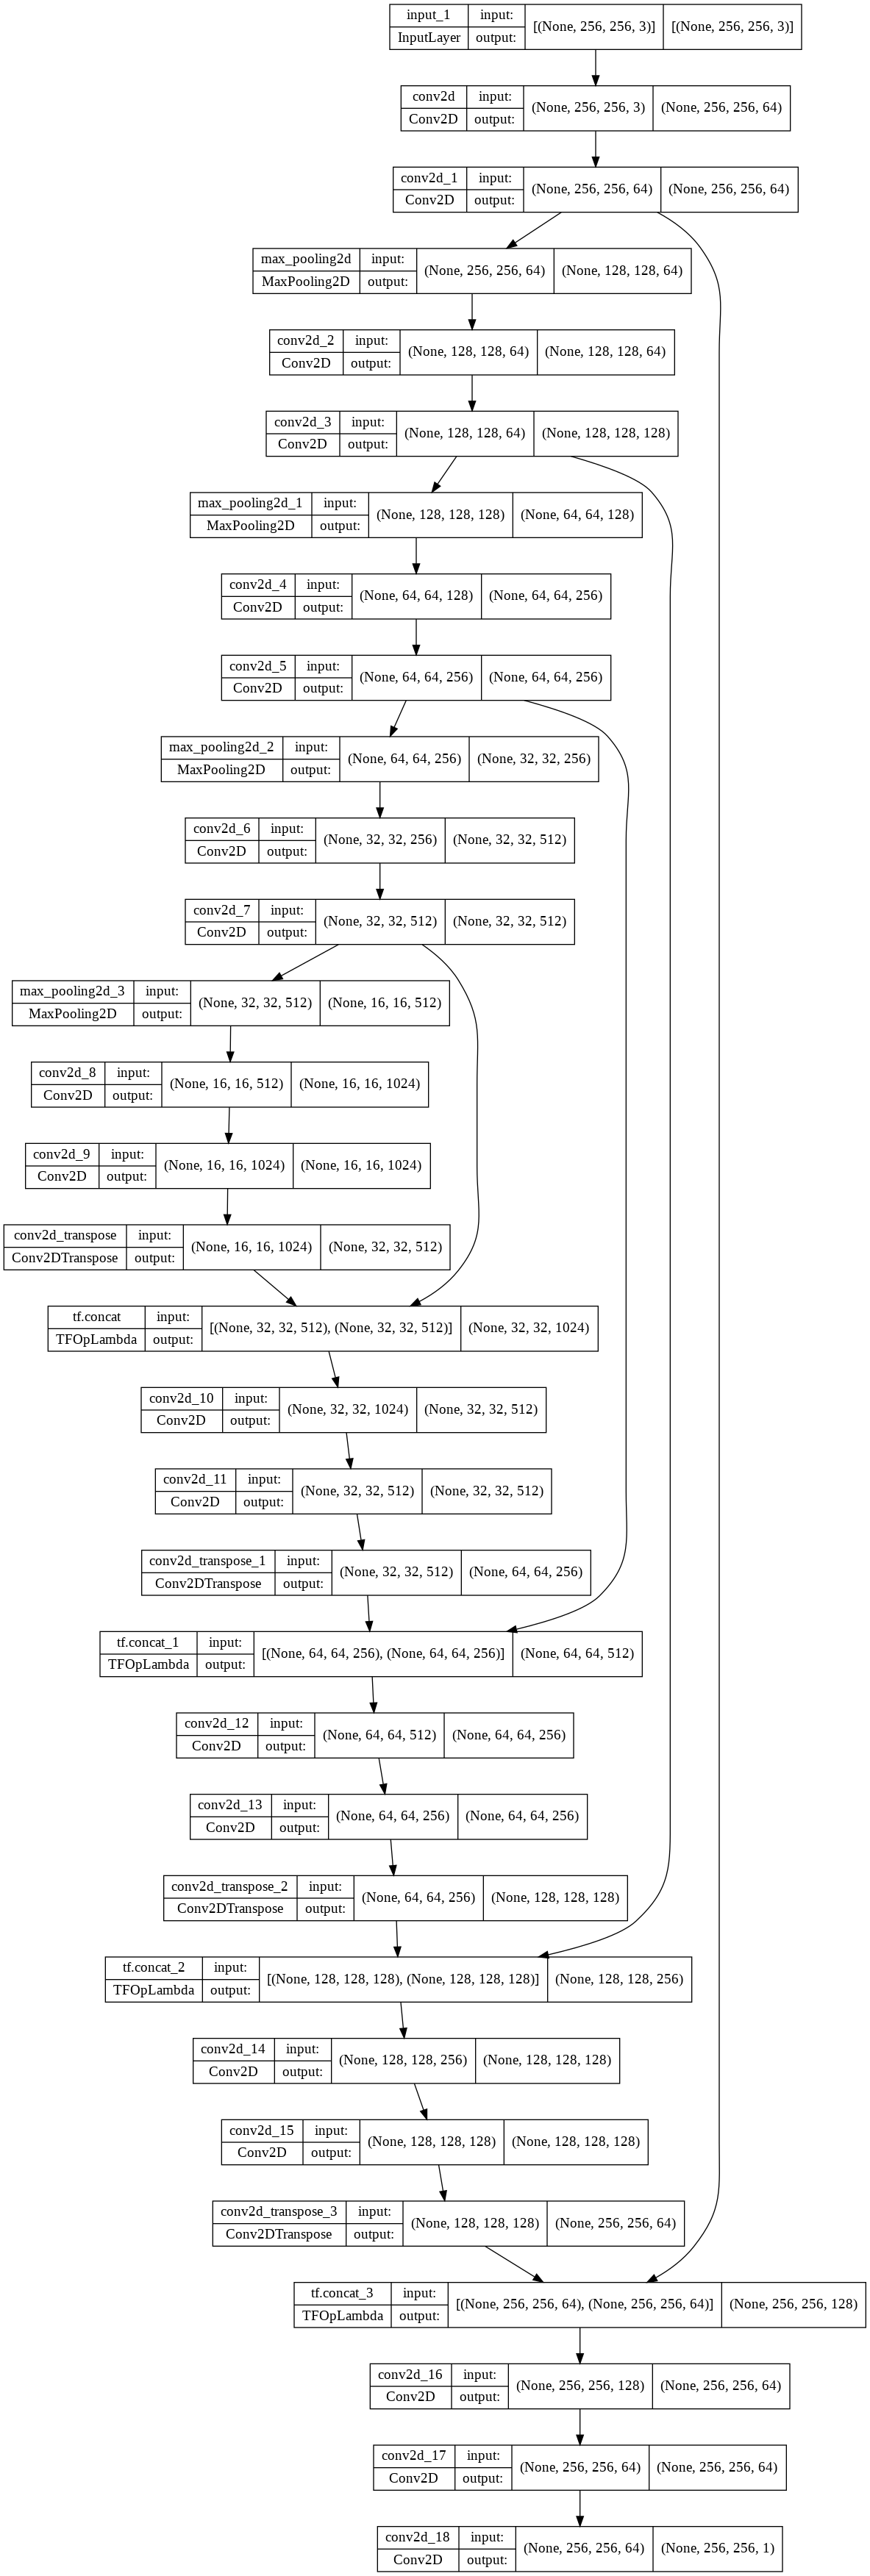

In [3]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Задания


**[ЗАДАНИЕ 1]** Вопрос: почему при создании модели UNet нам потребовались дополнительные имена для переменных типа `out1`, `out2`, `out3`, `out4`, хотя раньше мы всегда могли обойтись одним именем `out`?

**[Ответ:]** Потому что нам необходимо сохранять выходы некоторых слоев, чтобы конкатенировать их с выходами других слоев. Если сохранять выходы каждого слоя в `out`, он будет постоянно перезаписываться.


**[ЗАДАНИЕ 2]** Создайте новую модель, аналогичную описанной выше, в котрой замените все Pooling слои на свёрточные слои со страйдом 2, а все Conv2DTranspose слои на комбинацию Nearest Unpooling и обычного свёрточного слоя.

In [6]:
from tensorflow.keras.layers import Conv2D, UpSampling2D

def build_model_2():
  x = tf.keras.layers.Input((256, 256, 3))

  out = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  out1 = Conv2D(64, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out1)

  out = Conv2D(64, (3, 3), padding='same', activation='relu')(out)
  out2 = Conv2D(128, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out2)

  out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)
  out3 = Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out3)

  out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out4 = Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out4)

  out = Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

  out = UpSampling2D((2, 2))(out)
  out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  out = tf.concat([out, out4], axis=3)

  out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)

  out = UpSampling2D((2, 2))(out)
  out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out = tf.concat([out, out3], axis=3)

  out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)

  out = UpSampling2D((2, 2))(out)
  out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)
  out = tf.concat([out, out2], axis=3)

  out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)

  out = UpSampling2D((2, 2))(out)
  out = Conv2D(64, (3, 3), padding='same', activation='relu')(out)
  out = tf.concat([out, out1], axis=3)

  out = Conv2D(64, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(64, (3, 3), padding='same', activation='relu')(out)
  out = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

  model = tf.keras.Model(inputs=x, outputs=out)

  return model

model_new = build_model_2()


**[ЗАДАНИЕ 3]** Реализуйте пайплайн обучения для UNet модели: подготовка данных, лосс, обучение, тестирование. Используйте материалы из предыдущего практического урока. Обучите модель и сравните время обучения с временем обучения более простых версий FCN из предыдущих уроков.

In [8]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.

gt = imageio.imread('me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[...,None]

train_x = np.stack((img, img[:, ::-1, :]))
train_y = np.stack((gt, gt[:, ::-1, :]))

In [10]:
%%time
EPOCHS = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss)

history = model.fit(train_x, train_y, epochs=EPOCHS)

Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 0.6929
Epoch 2/100
1/1 [==============================] - 0s 401ms/step - loss: 0.6915
Epoch 3/100
1/1 [==============================] - 0s 410ms/step - loss: 0.6901
Epoch 4/100
1/1 [==============================] - 0s 401ms/step - loss: 0.6890
Epoch 5/100
1/1 [==============================] - 0s 401ms/step - loss: 0.6879
Epoch 6/100
1/1 [==============================] - 0s 401ms/step - loss: 0.6867
Epoch 7/100
1/1 [==============================] - 0s 402ms/step - loss: 0.6854
Epoch 8/100
1/1 [==============================] - 0s 408ms/step - loss: 0.6839
Epoch 9/100
1/1 [==============================] - 0s 399ms/step - loss: 0.6823
Epoch 10/100
1/1 [==============================] - 0s 413ms/step - loss: 0.6804
Epoch 11/100
1/1 [==============================] - 0s 403ms/step - loss: 0.6785
Epoch 12/100
1/1 [==============================] - 0s 399ms/step - loss: 0.6762
Epoch 13/100
1/1 [====================

In [11]:
%%time
EPOCHS = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()

model_new.compile(optimizer=optimizer, loss=loss)

history = model_new.fit(train_x, train_y, epochs=EPOCHS)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6934
Epoch 2/100
1/1 [==============================] - 1s 519ms/step - loss: 0.6919
Epoch 3/100
1/1 [==============================] - 1s 514ms/step - loss: 0.6906
Epoch 4/100
1/1 [==============================] - 1s 508ms/step - loss: 0.6894
Epoch 5/100
1/1 [==============================] - 1s 508ms/step - loss: 0.6883
Epoch 6/100
1/1 [==============================] - 1s 511ms/step - loss: 0.6869
Epoch 7/100
1/1 [==============================] - 1s 509ms/step - loss: 0.6852
Epoch 8/100
1/1 [==============================] - 1s 506ms/step - loss: 0.6830
Epoch 9/100
1/1 [==============================] - 1s 505ms/step - loss: 0.6801
Epoch 10/100
1/1 [==============================] - 1s 505ms/step - loss: 0.6758
Epoch 11/100
1/1 [==============================] - 1s 505ms/step - loss: 0.6690
Epoch 12/100
1/1 [==============================] - 1s 507ms/step - loss: 0.6575
Epoch 13/100
1/1 [======================